## Import modules

In [89]:
import pdb
import glob

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

import nhanes as nhanes

%matplotlib notebook

import importlib
importlib.reload(nhanes)

<module 'nhanes' from '/Users/qiwenlyu/Development/health/Health-Analytics-Opportunistic/nhanes.py'>

## Settings

In [90]:
DATA_PATH = '/Users/qiwenlyu/Development/health/NHANES/'
DATASET = 'arthritis'

### Note: 
The code below loads each dataset: dataset_features, dataset_targets

Here, all datasets are defined explicitly (see nhanes.py).

In [91]:
importlib.reload(nhanes)
ds = nhanes.Dataset(DATA_PATH)
ds.load_arthritis()
n_fe = ds.features.shape[1]
n_classes = 2

dataset_features = ds.features
dataset_targets = ds.targets

Processing: BPQ_I.XPT                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   

## Train/Test Separation

In [92]:
perm = np.random.permutation(dataset_targets.shape[0])
dataset_features = dataset_features[perm]
dataset_targets = dataset_targets[perm]

def get_batch(n_size, phase):
    # select indices
    n_samples = dataset_features.shape[0]
    n_classes = int(dataset_targets.max() + 1)
    if phase == 'test':
        inds_sel = np.arange(0, int(n_samples*0.15), 1)
    elif phase == 'validation':
        n_samples = dataset_features.shape[0]
        inds_sel = np.arange(int(n_samples*0.15), int(n_samples*0.30), 1)
    elif phase == 'train':
        n_samples = dataset_features.shape[0]
        inds_sel = np.arange(int(n_samples*0.30), n_samples, 1)
    else:
        raise NotImplementedError
    inds_sel = np.random.permutation(inds_sel)
    batch_inds = []
    for cl in range(n_classes):
        inds_cl = inds_sel[dataset_targets[inds_sel] == cl]
        batch_inds.extend(inds_cl[:n_size//n_classes])
    batch_inds = np.random.permutation(batch_inds)
    
    return dataset_features[batch_inds], dataset_targets[batch_inds]
    
features_trn, targets_trn = get_batch(n_size=5000, phase='train')
features_tst, targets_tst = get_batch(n_size=1000, phase='test')

## Classification

In [93]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting normalize=True.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

accu_tst_RFC 0.8453781512605042
Confusion matrix, without normalization
[[  7  88]
 [  4 496]]


<IPython.core.display.Javascript object>


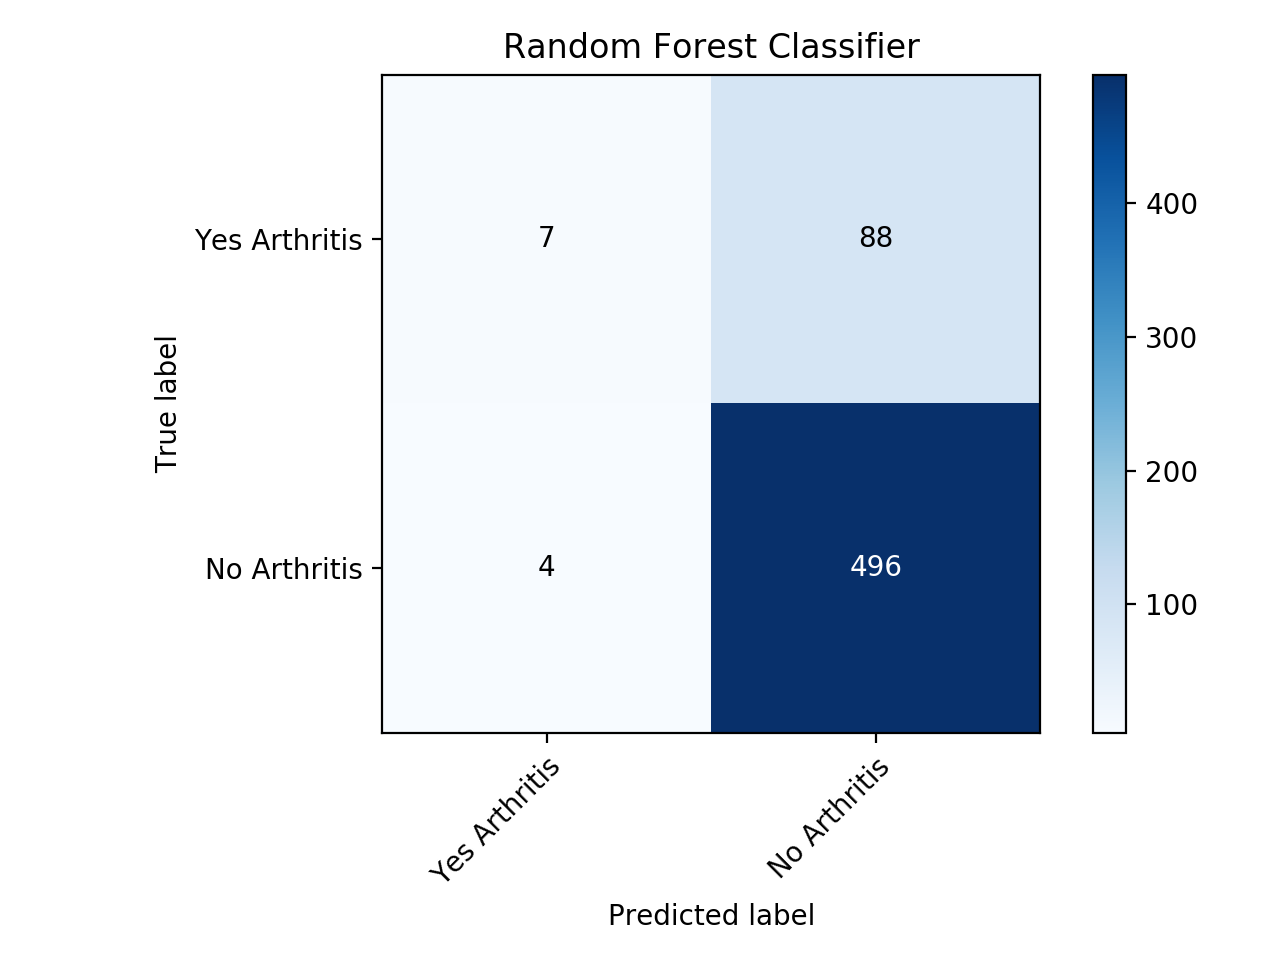

[[ 72  21]
 [131 369]]
accu_tst_SVC 0.7294117647058823
Confusion matrix, without normalization
[[ 63  32]
 [129 371]]


<IPython.core.display.Javascript object>


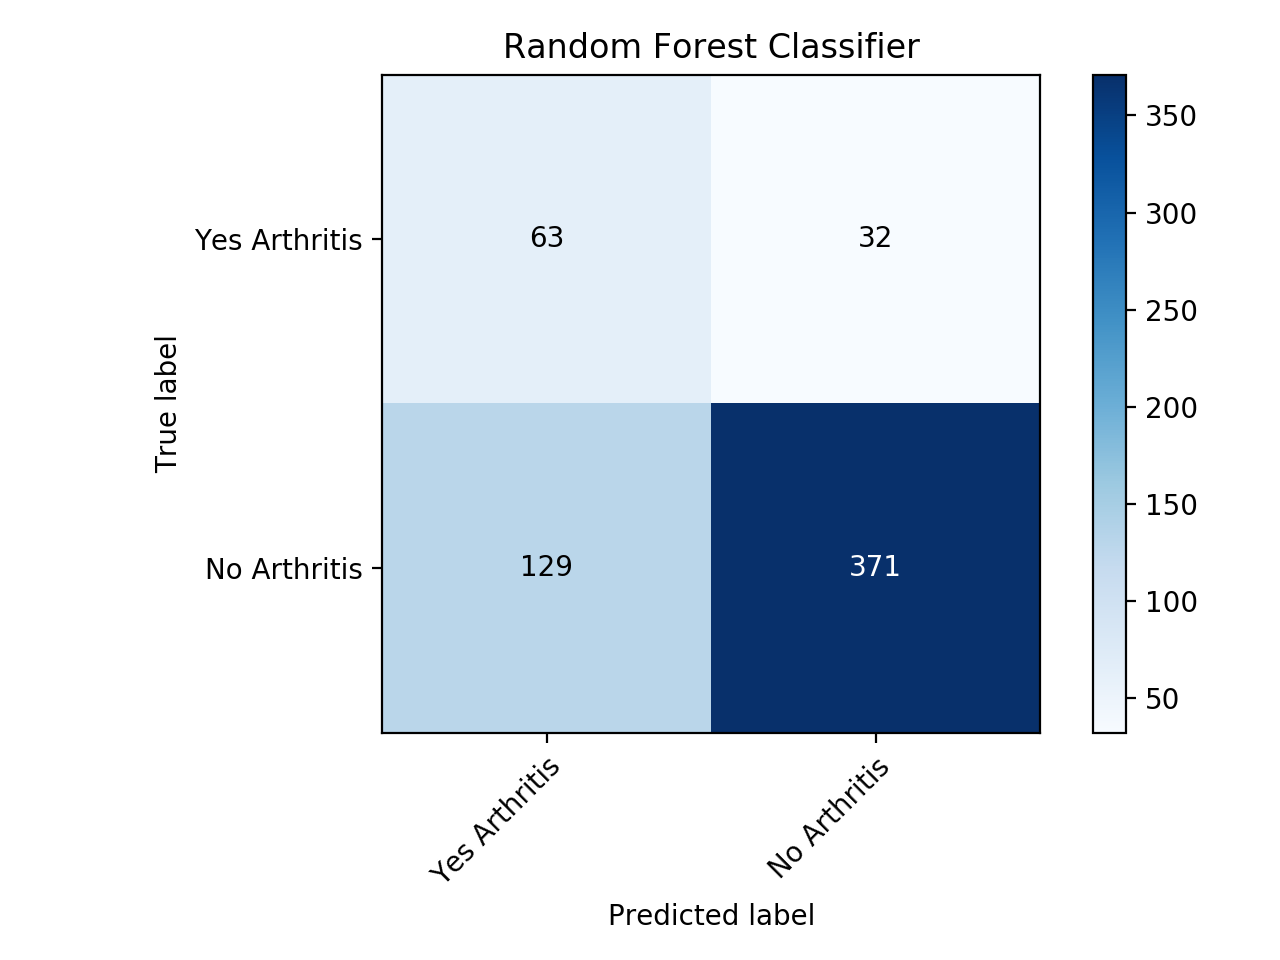

[[ 72  21]
 [131 369]]
accu_tst_LR 0.7277310924369748
Confusion matrix, without normalization
[[ 65  30]
 [132 368]]


/Users/qiwenlyu/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


<IPython.core.display.Javascript object>


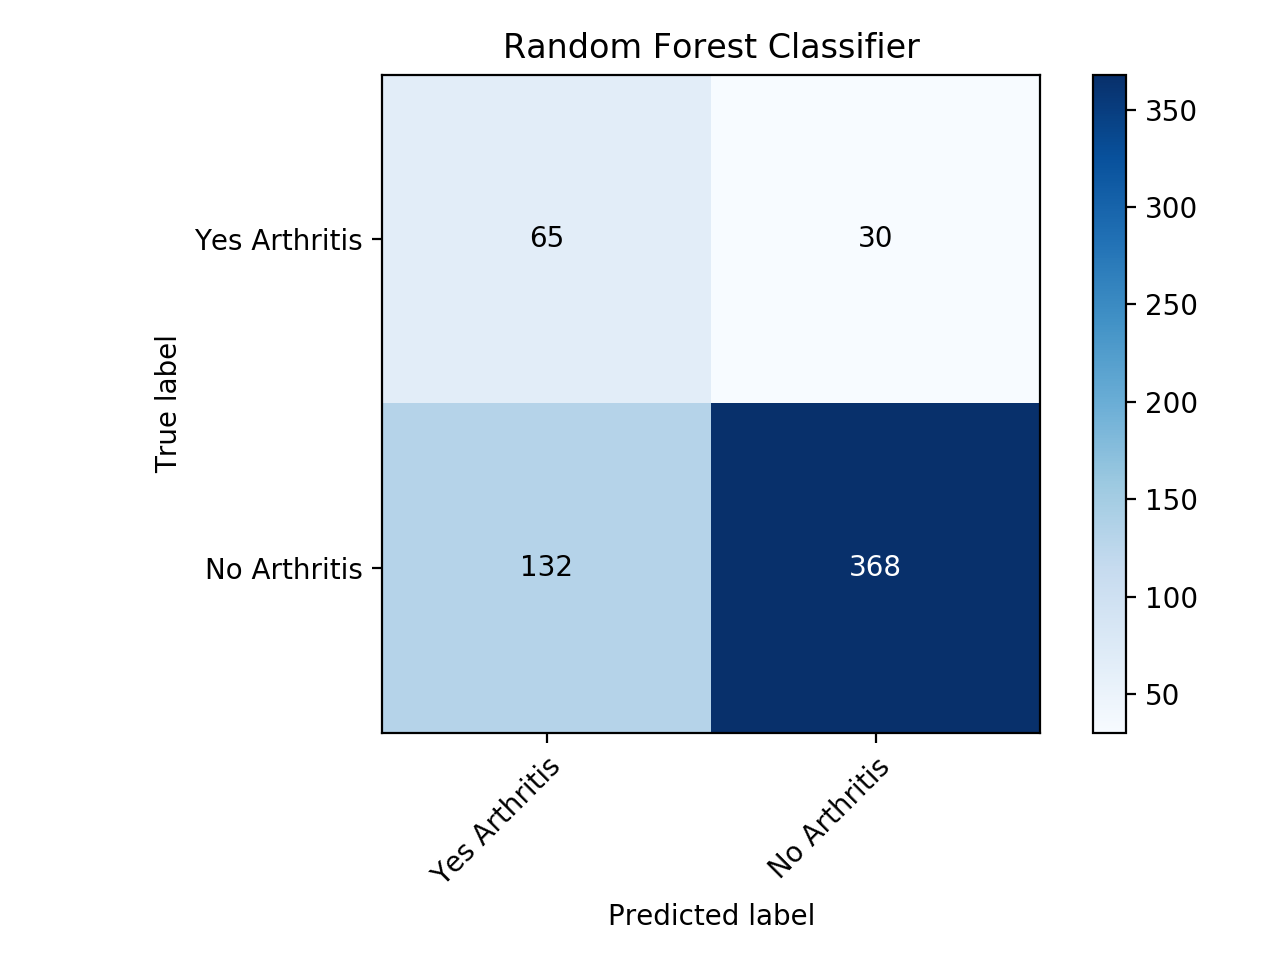

[[ 72  21]
 [131 369]]


In [94]:
from sklearn.metrics import confusion_matrix
clf = RandomForestClassifier(n_estimators=100,class_weight='balanced')
clf.fit(features_trn, targets_trn)
preds_tst = clf.predict(features_tst)
accu = np.mean(preds_tst==targets_tst)
print('accu_tst_RFC', accu)
#cm = confusion_matrix(targets_tst, preds_tst)
plot_confusion_matrix(targets_tst,preds_tst,classes=['Yes Arthritis', 'No Arthritis'],title='Random Forest Classifier')
print(cm)

clf = SVC(gamma='auto',class_weight='balanced')
clf.fit(features_trn, targets_trn)
preds_tst = clf.predict(features_tst)
accu = np.mean(preds_tst==targets_tst)
print('accu_tst_SVC', accu)
#cm = confusion_matrix(targets_tst, preds_tst)
plot_confusion_matrix(targets_tst,preds_tst,classes=['Yes Arthritis', 'No Arthritis'],title='Random Forest Classifier')
print(cm)

clf = LogisticRegression(solver='lbfgs', max_iter=200,class_weight='balanced')
clf.fit(features_trn, targets_trn)
preds_tst = clf.predict(features_tst)
accu = np.mean(preds_tst==targets_tst)
print('accu_tst_LR', accu)
#cm = confusion_matrix(targets_tst, preds_tst)
plot_confusion_matrix(targets_tst,preds_tst,classes=['Yes Arthritis', 'No Arthritis'],title='Random Forest Classifier')
print(cm)

